# Benchmark recombination and mutation rates estimation error and computation time

In [2]:
import numpy
import pandas
import seaborn
import recombulatorx
import recombulatorx.testing

In [3]:
try:
    from tqdm import tqdm
except ModuleNotFoundError:
    tqdm = lambda x: x
    print('tqdm module not found, no progress bars!')

In [4]:
from time import time

def random_estimation_test(n_markers, n_fam_I, n_fam_II, seed=None, **kwargs):
    if seed is not None:
        numpy.random.seed(seed)
    simulated_rates = recombulatorx.testing.generate_random_rates(n_markers)
    fams = [recombulatorx.testing.generate_processed_family(f'FAM_I_{i}', 2, True, *simulated_rates) for i in range(n_fam_I)]
    fams += [recombulatorx.testing.generate_processed_family(f'FAM_II_{i}', 2, False, *simulated_rates) for i in range(n_fam_II)]
    t1 = time()
    estimated_rates = recombulatorx.estimate_rates(fams, 0.1, 0.1, **kwargs)
    elapsed_time = time() - t1
    return simulated_rates, estimated_rates, elapsed_time

In [5]:
try:
    import joblib
    mem = joblib.Memory('estimation_testing_cache', verbose=0)
    random_estimation_test = mem.cache(random_estimation_test)
except ModuleNotFoundError:
    print('joblib module not found, cannot cache results')

In [6]:
def random_estimation_tests(n_markers, n_fam_I, n_fam_II, n_tests, **kwargs):
    data = [
        random_estimation_test(n_markers, n_fam_I, n_fam_II, seed, estimate_mutation_rates='all', **kwargs)
        for seed in tqdm(range(n_tests))
    ]
    # put results in a pandas DataFrame
    recomb_cols = [('RECOMBINATION', f'M{i}-{i+1}') for i in range(1, n_markers)]
    mut_cols = [('MUTATION', f'M{i}') for i in range(1, n_markers + 1)]
    all_cols = [(l1, *l2) for l1 in ['SIMULATED', 'ESTIMATED'] for l2_cols in [recomb_cols, mut_cols] for l2 in l2_cols] + [('ELAPSED TIME', None, None)]

    df = pandas.DataFrame(
        [
            numpy.concatenate([*simulated_rates, *estimated_rates, [elapsed_time]])
            for simulated_rates, estimated_rates, elapsed_time in data
        ], 
        columns=pandas.MultiIndex.from_tuples(all_cols, names=['SOURCE', 'RATE', 'MARKER']))
    df.index.name = 'TEST'
    return df

In [6]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='Nelder-Mead', maxiter=10000)

In [7]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='L-BFGS-B', maxiter=10000)

In [8]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='Powell', maxiter=10000)

In [9]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='TNC', maxiter=10000)

In [10]:
#random_estimation_tests(n_markers=12, n_fam_I=100, n_fam_II=0, n_tests=1)

## Tests comparing to literature

Nothnagel and colleagues analyzed 216 type I and 185 type II families genotyped with a panel of 12 markers \cite{Nothnagel_2012}

In [7]:
lit1 = random_estimation_tests(n_markers=12, n_fam_I=216, n_fam_II=185, n_tests=10)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
lit1_minutes = lit1.loc[:, ('ELAPSED TIME', None, None)]/60
print(f'average time (minutes): {lit1_minutes.mean()}, std: {lit1_minutes.std()}')

In [ ]:
lit2 = random_estimation_tests(n_markers=15, n_fam_I=54, n_fam_II=104, n_tests=10)

In [ ]:
lit2_minutes = lit2.loc[:, ('ELAPSED TIME', None, None)]/60
print(f'average time (minutes): {lit2_minutes.mean()}, std: {lit2_minutes.std()}')

# Tests varying the number of markers

In [28]:
n_fam_I = 100
n_fam_II = 0
marker_tests = {}
for n_markers in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 150]:
    print(f'{n_markers=}')
    marker_tests[n_markers] = random_estimation_tests(n_markers, n_fam_I, n_fam_II, 10)

n_markers=10


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.11it/s]


n_markers=20


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4358.17it/s]


n_markers=30


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4621.31it/s]


n_markers=40


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4553.58it/s]


n_markers=50


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4147.03it/s]


n_markers=60


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


n_markers=70


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


n_markers=80


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.10s/it]


n_markers=90


100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.30s/it]


n_markers=100


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4631.01it/s]


n_markers=110


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


n_markers=120


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


n_markers=130


 40%|█████████████████▌                          | 4/10 [00:08<00:12,  2.06s/it]

ValueError: Minimization failed to converge: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT

<AxesSubplot: xlabel='MARKERS', ylabel='ELAPSED TIME'>

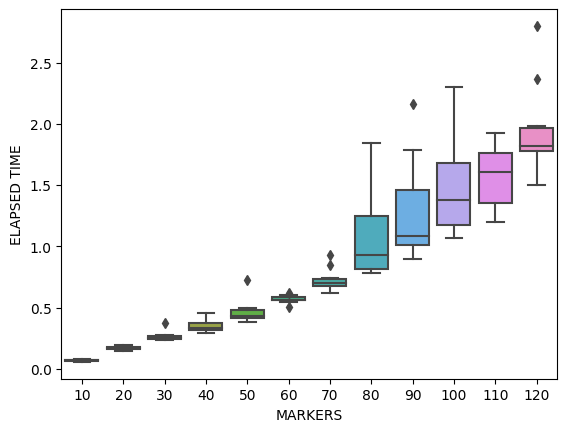

In [33]:
plot_data = pandas.concat({k: df[('ELAPSED TIME', None, None)] for k, df in marker_tests.items()}, names=['MARKERS']).reset_index()
plot_data.columns = plot_data.columns.get_level_values(0)
seaborn.boxplot(plot_data, x='MARKERS', y='ELAPSED TIME')

In [ ]:
acc = {}
mae_acc = {}
for n_markers, df in marker_tests.items():
    #delta = df['ESTIMATED'] - df['SIMULATED']
    #mae_acc[n_markers] = delta.abs().mean()
    #stats = delta.stack().apply(['mean', 'std'])
    #stats['TIME'] = df[('ELAPSED TIME', None, None)].apply(['mean', 'std'])
    #stats = stats.unstack(level=0)
    #stats['MAE'] = delta.abs().mean()
    #acc[n_markers] = stats
    #delta.apply(['mean', 'std'])
df = pandas.concat(acc, names=['n_markers'])
df

In [35]:
n_fam_I = 100
n_fam_II = 100
marker_tests_II = {}
for n_markers in [6, 8, 10, 12, 14]:
    print(f'{n_markers=}')
    marker_tests_II[n_markers] = random_estimation_tests(n_markers, n_fam_I, n_fam_II, 10)

n_markers=6




  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [00:01<00:11,  1.33s/it]

 20%|████████▊                                   | 2/10 [00:02<00:09,  1.23s/it]

 30%|█████████████▏                              | 3/10 [00:03<00:08,  1.24s/it]

 40%|█████████████████▌                          | 4/10 [00:05<00:07,  1.30s/it]

 50%|██████████████████████                      | 5/10 [00:06<00:06,  1.26s/it]

 60%|██████████████████████████▍                 | 6/10 [00:07<00:05,  1.29s/it]

 70%|██████████████████████████████▊             | 7/10 [00:08<00:03,  1.26s/it]

 80%|███████████████████████████████████▏        | 8/10 [00:10<00:02,  1.26s/it]

 90%|███████████████████████████████████████▌    | 9/10 [00:10<00:01,  1.13s/it]

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


n_markers=8




  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [00:04<00:40,  4.46s/it]

 20%|████████▊                                   | 2/10 [00:08<00:33,  4.20s/it]

 30%|█████████████▏                              | 3/10 [00:12<00:27,  3.95s/it]

 40%|█████████████████▌                          | 4/10 [00:15<00:22,  3.79s/it]

 50%|██████████████████████                      | 5/10 [00:19<00:18,  3.65s/it]

 60%|██████████████████████████▍                 | 6/10 [00:23<00:15,  3.99s/it]

 70%|██████████████████████████████▊             | 7/10 [00:27<00:11,  3.96s/it]

 80%|███████████████████████████████████▏        | 8/10 [00:31<00:07,  3.81s/it]

 90%|███████████████████████████████████████▌    | 9/10 [00:34<00:03,  3.70s/it]

100%|███████████████████████████████████████████| 10/10 [00:40<00:00,  4.04s/it]


n_markers=10




  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [00:21<03:13, 21.47s/it]

 20%|████████▊                                   | 2/10 [00:37<02:25, 18.18s/it]

 30%|█████████████▏                              | 3/10 [00:53<02:00, 17.25s/it]

 40%|█████████████████▌                          | 4/10 [01:08<01:38, 16.46s/it]

 50%|██████████████████████                      | 5/10 [01:25<01:22, 16.48s/it]

 60%|██████████████████████████▍                 | 6/10 [01:38<01:01, 15.30s/it]

 70%|██████████████████████████████▊             | 7/10 [01:59<00:51, 17.18s/it]

 80%|███████████████████████████████████▏        | 8/10 [02:20<00:37, 18.54s/it]

 90%|███████████████████████████████████████▌    | 9/10 [02:37<00:17, 17.87s/it]

100%|███████████████████████████████████████████| 10/10 [02:55<00:00, 17.55s/it]


n_markers=12




  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [01:05<09:53, 65.99s/it]

 20%|████████▊                                   | 2/10 [02:13<08:54, 66.79s/it]

 30%|█████████████▏                              | 3/10 [03:35<08:35, 73.65s/it]

 40%|█████████████████▌                          | 4/10 [04:38<06:57, 69.57s/it]

 50%|██████████████████████                      | 5/10 [05:42<05:38, 67.62s/it]

 60%|██████████████████████████▍                 | 6/10 [06:44<04:22, 65.67s/it]

 70%|██████████████████████████████▊             | 7/10 [08:01<03:28, 69.37s/it]

 80%|███████████████████████████████████▏        | 8/10 [09:08<02:17, 68.65s/it]

leaf monotonicity failure 2.0272426552955824e-20 2.0272426552955845e-20 -2.1064858766735392e-35 -1.0390891643735666e-15




 90%|███████████████████████████████████████▌    | 9/10 [10:26<01:11, 71.63s/it]

leaf monotonicity failure 1.0890980241519756e-31 1.0890980241519766e-31 -1.0947644252537633e-46 -1.0052028384737901e-15
leaf monotonicity failure 1.1685653631923688e-12 1.16856536319237e-12 -1.2116903504194741e-27 -1.036904214847933e-15
leaf monotonicity failure 6.429172842209437e-10 6.429172842209444e-10 -7.237830359838992e-25 -1.12577940233936e-15
leaf monotonicity failure 6.429172842209437e-10 6.429172842209444e-10 -7.237830359838992e-25 -1.12577940233936e-15
leaf monotonicity failure 7.391166265299832e-10 7.391166265299841e-10 -8.271806125530277e-25 -1.1191476187411556e-15




100%|███████████████████████████████████████████| 10/10 [11:40<00:00, 70.03s/it]


n_markers=14




  0%|                                                    | 0/10 [00:00<?, ?it/s]

leaf monotonicity failure 1.5027808683971296e-10 1.5027808683971311e-10 -1.550963648536927e-25 -1.0320624125267097e-15




 10%|████▎                                      | 1/10 [04:21<39:16, 261.83s/it]

 20%|████████▌                                  | 2/10 [10:14<42:03, 315.40s/it]

leaf monotonicity failure 2.6063563645342994e-12 2.6063563645343022e-12 -2.8272774843121063e-27 -1.0847624380088475e-15
leaf monotonicity failure 5.316216980348424e-25 5.3162169803484305e-25 -6.428484731059385e-40 -1.2092216617234564e-15
leaf monotonicity failure 1.05177586634722e-29 1.0517758663472211e-29 -1.1210387714598537e-44 -1.0658532937755837e-15




 30%|████████████▉                              | 3/10 [16:04<38:37, 331.00s/it]

leaf monotonicity failure 1.8788339243917528e-44 1.8788339243917548e-44 -1.9913648889155653e-59 -1.0598940454836851e-15
leaf monotonicity failure 1.185491287079196e-12 1.1854912870791973e-12 -1.2116903504194741e-27 -1.0220997519136778e-15
leaf monotonicity failure 1.7101874291472456e-33 1.7101874291472473e-33 -1.7105694144590052e-48 -1.000223358741415e-15
leaf monotonicity failure 2.5660540378053564e-38 2.566054037805359e-38 -2.61012178719941e-53 -1.0171733520591562e-15




 40%|█████████████████▏                         | 4/10 [20:20<30:08, 301.35s/it]

 50%|█████████████████████▌                     | 5/10 [25:29<25:20, 304.09s/it]

 60%|█████████████████████████▊                 | 6/10 [31:33<21:37, 324.45s/it]

leaf monotonicity failure 6.520645114312715e-17 6.520645114312722e-17 -7.395570986446986e-32 -1.1341778086057487e-15
leaf monotonicity failure 7.131666128360847e-18 7.131666128360855e-18 -7.703719777548943e-33 -1.0802131842534207e-15
leaf monotonicity failure 1.7363320301538376e-14 1.7363320301538395e-14 -1.8932661725304283e-29 -1.0903825648846e-15
leaf monotonicity failure 4.810394285878838e-13 4.810394285878843e-13 -5.048709793414476e-28 -1.0495417825177491e-15
leaf monotonicity failure 2.4257890514477505e-16 2.425789051447753e-16 -2.465190328815662e-31 -1.0162426643587963e-15
leaf monotonicity failure 7.415959793282704e-18 7.415959793282712e-18 -7.703719777548943e-33 -1.0388027972491005e-15
leaf monotonicity failure 1.1372231813241135e-18 1.1372231813241146e-18 -1.1555579666323415e-33 -1.0161224160827244e-15
leaf monotonicity failure 1.2148570123601173e-16 1.2148570123601186e-16 -1.232595164407831e-31 -1.014601020422356e-15
leaf monotonicity failure 1.8340396107008927e-17 1.83403961



 70%|██████████████████████████████             | 7/10 [37:03<16:19, 326.45s/it]

leaf monotonicity failure 5.428975051855335e-12 5.428975051855341e-12 -5.6545549686242126e-27 -1.041551105800676e-15




 80%|██████████████████████████████████▍        | 8/10 [43:22<11:26, 343.26s/it]

leaf monotonicity failure 9.828263356817464e-13 9.828263356817474e-13 -1.0097419586828951e-27 -1.0273859399407296e-15
leaf monotonicity failure 5.864059629694146e-20 5.864059629694152e-20 -6.018531076210112e-35 -1.0263420661232287e-15




 90%|██████████████████████████████████████▋    | 9/10 [47:57<05:21, 321.94s/it]

leaf monotonicity failure 1.7951614926078096e-16 1.7951614926078116e-16 -1.9721522630525295e-31 -1.0985932302879366e-15
leaf monotonicity failure 2.182654126281246e-18 2.1826541262812482e-18 -2.311115933264683e-33 -1.0588557781265622e-15
leaf monotonicity failure 2.4546718643480755e-17 2.454671864348078e-17 -2.465190328815662e-32 -1.0042850796558006e-15
leaf monotonicity failure 6.2391006904048e-15 6.239100690404806e-15 -6.310887241768095e-30 -1.0115059132598532e-15
leaf monotonicity failure 5.999749730386769e-10 5.999749730386775e-10 -6.203854594147708e-25 -1.0340188962761576e-15
leaf monotonicity failure 2.219476864348192e-15 2.2194768643481943e-15 -2.3665827156630354e-30 -1.0662795155371186e-15




100%|██████████████████████████████████████████| 10/10 [52:50<00:00, 317.05s/it]


In [ ]:
plot_data = pandas.concat({k: df[('ELAPSED TIME', None, None)] for k, df in marker_tests_II.items()}, names=['MARKERS']).reset_index()
plot_data.columns = plot_data.columns.get_level_values(0)
seaborn.boxplot(plot_data, x='MARKERS', y='ELAPSED TIME')

In [10]:
acc = {}
mae_acc = {}
for n_markers, df in marker_tests.items():
    delta = df['ESTIMATED'] - df['SIMULATED']
    mae_acc[n_markers] = delta.abs().mean()
    stats = delta.stack().apply(['mean', 'std'])
    stats['TIME'] = df[('ELAPSED TIME', None, None)].apply(['mean', 'std'])
    #stats = stats.unstack(level=0)
    #stats['MAE'] = delta.abs().mean()
    acc[n_markers] = stats
    #delta.apply(['mean', 'std'])
df = pandas.concat(acc, names=['n_markers'])
df

RATE            MUTATION  RECOMBINATION      TIME
n_markers                                        
12        mean  0.001114       0.001223  0.089408
          std   0.009113       0.020649  0.008395
15        mean -0.000511       0.000217  0.116080
          std   0.010043       0.020480  0.010032
20        mean  0.000260      -0.001661  0.169006
          std   0.009827       0.017495  0.016153
30        mean  0.000537      -0.000059  0.264467
          std   0.009098       0.013640  0.041835
40        mean  0.000054       0.000112  0.345845
          std   0.008482       0.011433  0.049134
50        mean  0.000073       0.000623  0.465167
          std   0.008871       0.010928  0.097440
75        mean -0.000020      -0.000488  0.930022
          std   0.008716       0.008253  0.339196
100       mean -0.000402      -0.000272  1.469424
          std   0.009116       0.007517  0.392090
125       mean -0.000075      -0.000015  2.249259
          std   0.008695       0.006711  0.547032

In [11]:
pandas.concat(mae_acc, names=['n_markers']).reset_index().groupby(['n_markers', 'RATE']).mean()

/tmp/ipykernel_4750/4280286893.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pandas.concat(mae_acc, names=['n_markers']).reset_index().groupby(['n_markers', 'RATE']).mean()


0
n_markers RATE                   
12        MUTATION       0.006163
          RECOMBINATION  0.015217
15        MUTATION       0.006846
          RECOMBINATION  0.014092
20        MUTATION       0.006935
          RECOMBINATION  0.012518
30        MUTATION       0.006271
          RECOMBINATION  0.009589
40        MUTATION       0.005923
          RECOMBINATION  0.008142
50        MUTATION       0.006332
          RECOMBINATION  0.007424
75        MUTATION       0.006035
          RECOMBINATION  0.005861
100       MUTATION       0.006333
          RECOMBINATION  0.005212
125       MUTATION       0.006051
          RECOMBINATION  0.004613

In [ ]:
df.loc[(slice(None), slice('mean')), :]

In [ ]:
if False:
    n_markers = 12
    delta = marker_tests[n_markers]['ESTIMATED'] - marker_tests[n_markers]['SIMULATED']
    delta.to_csv('delta12.csv')
    delta.columns = delta.columns.get_level_values('MARKER')
    delta.boxplot(figsize=(8, 4))
    import matplotlib.pyplot as plt
    plt.xticks(rotation=90);
    plt.savefig('deltas12.pdf')

In [ ]:
print(pandas.concat(acc, names=['n_markers']).to_latex())

# Tests varying the number of families

In [ ]:
n_markers = 15
n_fam_II = 0
n_tests = 100
fam_I_acc = {}
for n_fam_I_log2 in range(1, 11):
    n_fam_I = 2**n_fam_I_log2
    fam_I_acc[n_fam_I] = random_estimation_tests(n_markers, n_fam_I, n_fam_II, n_tests)

In [ ]:
assert False

In [ ]:
delta = df['ESTIMATED'] - df['SIMULATED']
delta.head()

In [ ]:
delta.apply(['mean', 'std'])

In [ ]:
delta.plot.box()

In [ ]:
ratio = numpy.log2(df['ESTIMATED']/df['SIMULATED'])
ratio.head()

In [ ]:
r = ratio.stack(['RATE', 'MARKER'])
s = df.loc[:, 'SIMULATED'].stack(['RATE', 'MARKER'])
r.loc[s >= 1e-3].unstack(['RATE', 'MARKER']).plot.box()

In [ ]:
r.loc[s >= 1e-3].std()

In [ ]:
r.loc[s >= 1e-2].unstack(['RATE', 'MARKER']).quantile([0.025, 0.5, 0.975])

In [ ]:
seaborn.displot(r.loc[s >= 1e-2])

In [ ]:
pandas.concat([
    df.drop('ELAPSED TIME', axis=1).stack(['RATE', 'MARKER']), 
    pandas.DataFrame({'r': r, 's': s})
], axis=1).sort_values('r')

In [ ]:
s >= 1e04

In [ ]:
delta.loc[sorted(delta.abs().idxmax())]

In [ ]:
df.loc[sorted(delta.abs().idxmax()), (['SIMULATED', 'ESTIMATED'], 'RECOMBINATION', )]

In [ ]:
df.loc[sorted(delta.abs().idxmax()), [('SIMULATED', 'RECOMBINATION')]]

In [ ]:
seaborn.boxplot(data=delta)

In [ ]:
seaborn.displot(df[('ELAPSED TIME', None, None)])